# Anonymeter

This example notebook will demonstrate how to use `Anonymeter` to assess the Singling Out, Linkability, and Inference risk which might incour to data donors following the release of synthetic dataset. 

For this example, we will use the [`Adults`](https://archive.ics.uci.edu/ml/datasets/adult) dataset. The synthetic version has been generated by [`CTGAN`](https://sdv.dev/SDV/user_guides/single_table/ctgan.html), as explained in the paper accompanying this code release. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

## Load the data

In [2]:
bucket_url = "https://storage.googleapis.com/statice-public/anonymeter-datasets/"

train = pd.read_csv(os.path.join(bucket_url, "adults_train.csv"))
syn = pd.read_csv(os.path.join(bucket_url, "adults_syn_ctgan.csv"))
control = pd.read_csv(os.path.join(bucket_url, "adults_control.csv"))

train.shape, syn.shape, control.shape

((39074, 15), (39040, 15), (9768, 15))

In [3]:
train.head()

,age,type_employer,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income
0,53,Self-emp-not-inc,138022,11th,7,Divorced,Craft-repair,Not-in-family,White,Male,0,0,60,United-States,<=50K
1,45,Private,120131,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1887,40,United-States,>50K
2,31,Private,344200,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
3,28,Private,242482,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,United-States,<=50K
4,39,Self-emp-not-inc,360814,12th,8,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K


# Measuring the singling out risk

The `SinglingOutEvaluator` try to measure how much the synthetic data can help an attacker finding combination of attributes that single out records in the training data. 

In [4]:
evaluator = SinglingOutEvaluator(ori=train, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=500)
evaluator.evaluate(mode='univariate')

risk = evaluator.risk()
print(risk)

PrivacyRisk(value=0.0027538335768757193, ci=(0.0, 0.028078537884179182))


Using the `queries()` method, we can see what kind of singling out queries the attacker has come up with.

In [5]:
evaluator.queries()[:2]

['fnlwgt == 83742', 'fnlwgt == 261897']

### Conclusions so far

As visible, the `fnlwgt` attribute has many distinct values and as such is used by the attacker to build up successful univariate predicates. This leads to a non negligible risk of roughly 4% (the actual value might depend on the notebook run).

### Inspecting the results

There are two methods to inspect the results. `risk()`gives the high level estimation of the privacy risk, and it's confidence interval.

In [6]:
evaluator.risk(confidence_level=0.95)

PrivacyRisk(value=0.0027538335768757193, ci=(0.0, 0.028078537884179182))

for more informations, the `results()` method gives the success rates of the three attacks (the "main" one, the baseline one, and the one against control) that enters `Anonymeter` risk calculaiton.

In [7]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.04350719661231403, error=0.01746639922253677)
Successs rate of baseline attack: SuccessRate(value=0.007781672868929911, error=0.006684042346247121)
Successs rate of control attack: SuccessRate(value=0.040865900925556385, error=0.016926145922664525)


Note that you can obtain the `PrivacyRisk` from the attack results by:

In [8]:
res.risk()

PrivacyRisk(value=0.0027538335768757193, ci=(0.0, 0.028078537884179182))

### Checking singling out with multivariate predicates

The `SinglingOutEvaluator` can also attack the dataset using predicates which are combining different attributes. These are the so called `multivariate` predicates. To use them in the analysis, do:

In [9]:
evaluator = SinglingOutEvaluator(ori=train, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=100, # this attack takes longer
                                 n_cols=4)
evaluator.evaluate(mode='multivariate')

evaluator.risk()

PrivacyRisk(value=0.04294779228091197, ci=(0.0, 0.1433889159191506))

In [10]:
evaluator.queries()[:3]

["capital_loss>= 2033 & marital== 'Married-civ-spouse' & age>= 41 & race== 'Other'",
 "type_employer== 'Self-emp-inc' & relationship== 'Husband' & hr_per_week>= 85 & age<= 28",
 "country== 'Guatemala' & relationship== 'Not-in-family' & sex== 'Male' & income== '>50K'"]

# Measuring the Linkability risk

The `LinkabilityEvaluator` allows one to know how much the synthetic data will help an adversary who tries to link two other datasets based on a subset of attributes. 

For example, suppose that the adversary finds dataset A containing, among other fields, information about the profession and education of people, and dataset B containing some demographic and health related information. Can the attacker use the syntetic dataset to link these two datasets?

In [11]:
aux_cols = [
    ['type_employer', 'education', 'hr_per_week', 'capital_loss', 'capital_gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'country']
]

evaluator = LinkabilityEvaluator(ori=train, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=2000,
                                 aux_cols=aux_cols,
                                 n_neighbors=10)
evaluator.evaluate(n_jobs=-2)
evaluator.risk()

PrivacyRisk(value=0.0010035522088185356, ci=(0.0, 0.005595369635718563))

In [12]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.006447979880579577, error=0.0033740828710357583)
Successs rate of baseline attack: SuccessRate(value=0.003453731022423335, error=0.00238542229400942)
Successs rate of control attack: SuccessRate(value=0.005449896927860829, error=0.0030806162908989933)


As visible, the attack is not very successful and the linkability risk is low. The `n_neighbor` parameter can be used to allow for weaker indirect links to be scored as successes. It will have an inpact on the risk estimate. To check the measured risk for different values of `n_neighbor` you don't have to re-run the evaluation. Rather, do:

In [13]:
evaluator.risk(n_neighbors=5)

PrivacyRisk(value=0.0, ci=(0.0, 0.0027405627684715236))

# Measuring the Inference Risk

Finally, `anonymeter` allows to measure the inference risk. It does so by measureing the success of an attacker that tries to discover the value of some secret attribute for a set of target records on which some auxiliary knowledge is available.

By repeating the analysis targeting each dataset column, we can measure which one are more exposed to inference leak. 

In [14]:
columns = train.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=train, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=1000)
    evaluator.evaluate(n_jobs=-2)
    results.append(evaluator.results())

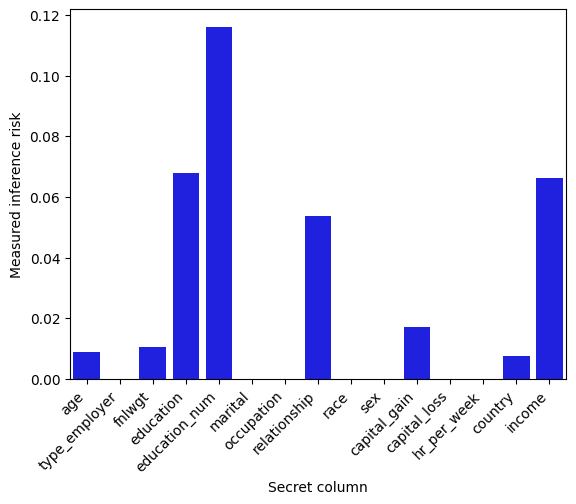

In [15]:
ax = sns.barplot(x=columns, y=[res.risk().value for res in results], color='b')
plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")